In [1]:
import numpy as np
import random, librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

### TESTING SOUND MAKER

In [2]:
def sound_maker(sample_rate, freq, max_amplitude, num_harmonics, 
                tone_duration, harmonic_factor):

    # Create the time array
    t = np.linspace(0, tone_duration, int(sample_rate * tone_duration), endpoint=False)
     
    # Initialize the sound array
    sound = np.zeros_like(t)
    
    # Generate the harmonics
    for k in range(1, num_harmonics + 1):
        omega = 2 * np.pi * freq * k
        harmonic = np.sin(omega * t)
        amplitude = max_amplitude * (harmonic_factor ** (k - 1))
        sound += amplitude * harmonic

    return sound

In [3]:
sample_rate = 48000    # Sample rate in Hz
freq = 392             # Frequency in Hz: A - 440; G - 392; C - 261.63
num_harmonics = 5      # Number of harmonics
tone_duration = 0.05    # Duration of each tone in seconds
harmonic_factor = 0.3  # Harmonic amplitude decay factor
A_max = 1.1            # Maximum amplitude
noramp_sound = sound_maker(sample_rate, freq, A_max, num_harmonics, tone_duration, harmonic_factor)

In [4]:
# Listen to the sound with Jupyter's Audio widget
Audio(noramp_sound, rate = sample_rate)

#### Visualize the generated sound with librosa

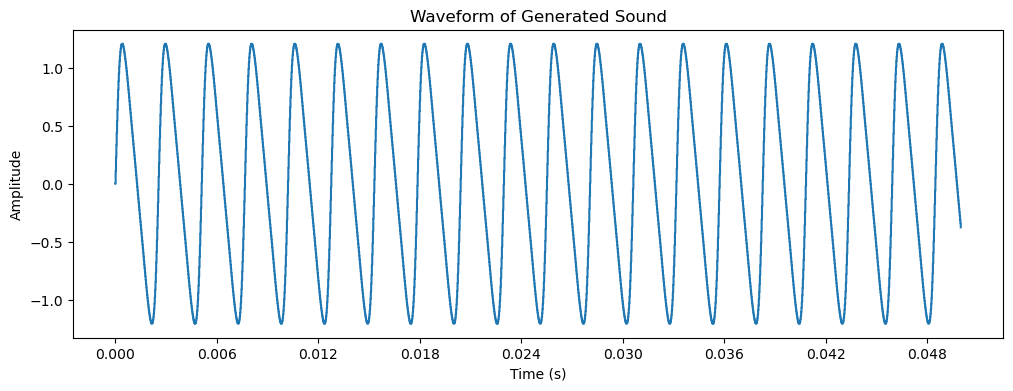

In [5]:
# ---- Plot waveform ----
plt.figure(figsize = (12, 4))
librosa.display.waveshow(noramp_sound, sr = sample_rate)
plt.title('Waveform of Generated Sound')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

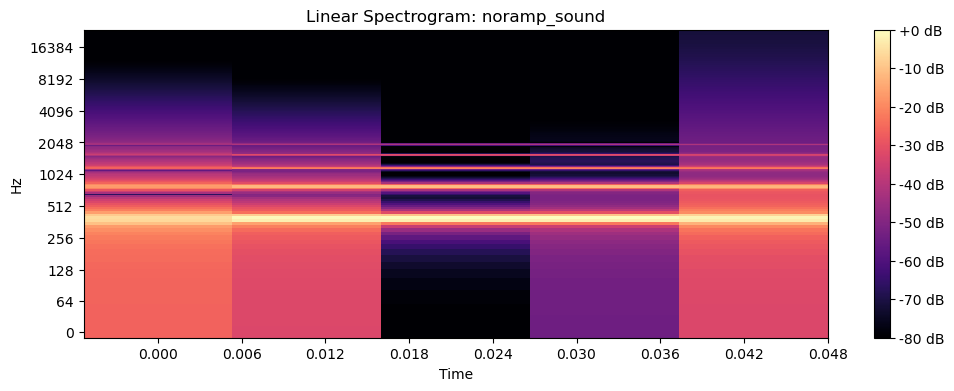

In [6]:
# ---- Plot spectrogram ----
D = librosa.stft(noramp_sound) # Compute short-time Fourier transform
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max) # Map magnitudes to decibel scale

plt.figure(figsize = (12, 4))
librosa.display.specshow(S_db, sr = sample_rate, x_axis = 'time', y_axis = 'log')
plt.colorbar(format="%+2.f dB")
plt.title('Linear Spectrogram: noramp_sound')
plt.show()

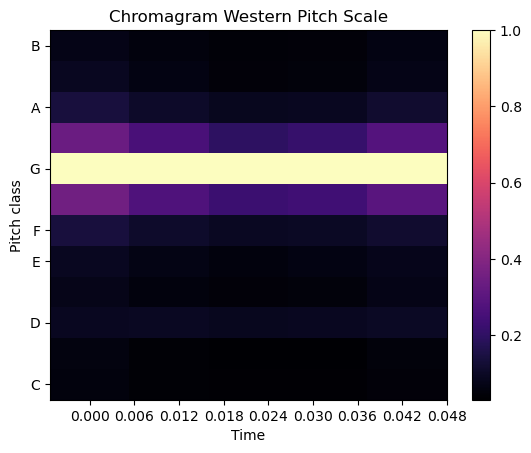

In [20]:
chroma = librosa.feature.chroma_cqt(y = ramped_sound, sr = sample_rate)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma, sr = sample_rate, n_fft=256, y_axis = 'chroma', x_axis = 'time',
                               ax=ax)
ax.set(title='Chromagram Western Pitch Scale')
fig.colorbar(img, ax=ax)

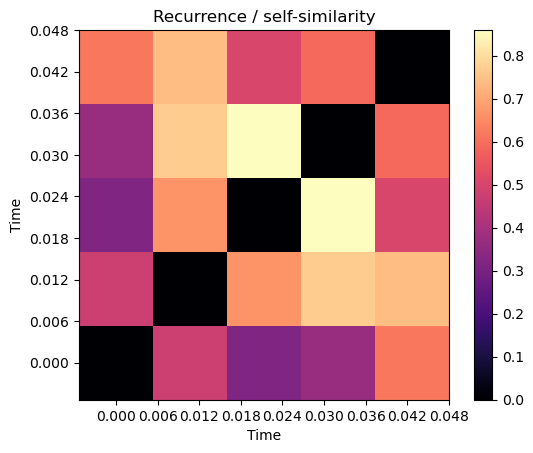

In [8]:
R = librosa.segment.recurrence_matrix(chroma, mode='affinity')
fig, ax = plt.subplots()
img = librosa.display.specshow(R, sr = sample_rate, y_axis='time', x_axis='time', ax=ax)
ax.set(title='Recurrence / self-similarity')
fig.colorbar(img, ax=ax)

### TESTING RAMP

In [9]:
def sine_ramp(sample_rate, tau, sound):
    tau = tau / 1000
    L = int(tau * sample_rate)
    t = np.linspace(0, L / sample_rate, L)
    sine_window = np.sin(np.pi * t / (2 * tau)) ** 2  # Sine fade-in

    sound = sound.copy()
    sound[:L] *= sine_window         # Apply fade-in
    sound[-L:] *= sine_window[::-1]  # Apply fade-out

    return sound

In [10]:
tau = 5  # Ramping window in seconds

ramped_sound = sine_ramp(sample_rate, tau, noramp_sound)
Audio(ramped_sound, rate = sample_rate)

### TESTING SEQUENCE GENERATION

In [11]:
isi = 0.7     # Inter-stimulus interval in seconds
no_tones = 7  # Number of tones in the sequence
delta = 0.2   # Displacement in seconds

In [12]:
np.random.seed(4)

# Calculate the number of tones that can fit into the total duration
isi_samples   = int(isi * sample_rate)  # How many events/samples occur in one isi
delta_samples = int(delta * sample_rate)
tone_samples  = int(tone_duration * sample_rate)
total_samples = int(tone_samples * no_tones + (no_tones - 1) * isi_samples)

In [13]:
# Pick a random tone to displace. Do not displace the first 3 tones or the last one.
displaced_tone = np.random.randint(4, no_tones)  # Include the first, excludes the final

#### SEQUENCE GENERATION FUNCTION (CHANGED)

In [16]:
# Generate sequence with ISI gaps between each tone
sequence = np.array([])

for tone_idx in range(no_tones):
    
    # ----------------- Adding tones ------------------
    sequence = np.concatenate((sequence, ramped_sound))

    # ----------------- Adding ISI --------------------
    # Add ISI after last tone to prevent abrupt end
    if tone_idx == no_tones - 2:
        sequence = np.concatenate((sequence, np.zeros(isi_samples)))
    
    # Change the ISI before the displaced tone
    if tone_idx == displaced_tone - 2:
        
        # Positive delta (delay)
        if delta > 0:
            isi_before = isi_samples + delta_samples
            isi_after  = isi_samples - delta_samples
            if isi_after <= 0:
                raise ValueError(f"Displacement is set too big: delta = {delta} sec. Reduce delta or increase ISI.")
            sequence = np.concatenate((sequence, np.zeros(isi_before)))

        # Negative delta (advance)
        elif delta < 0:
            isi_before = isi_samples - np.abs(delta_samples)
            isi_after  = isi_samples + np.abs(delta_samples)
            if isi_before <= 0:
                raise ValueError(f"Displacement is set too big: delta = {delta} sec. Reduce delta or increase ISI.")
            sequence = np.concatenate((sequence, np.zeros(isi_before)))
       
       # Zero delta (on-time)
        elif delta == 0:
            sequence = np.concatenate((sequence, np.zeros(isi_samples)))
    
    # Change the ISI after the displaced tone
    elif tone_idx == displaced_tone - 1:
        sequence = np.concatenate((sequence, np.zeros(isi_after)))
        
    # Add ISI after a regular tone
    else:
        sequence = np.concatenate((sequence, np.zeros(isi_samples)))

# Play sequence to check it's as it should be
Audio(sequence, rate = sample_rate)

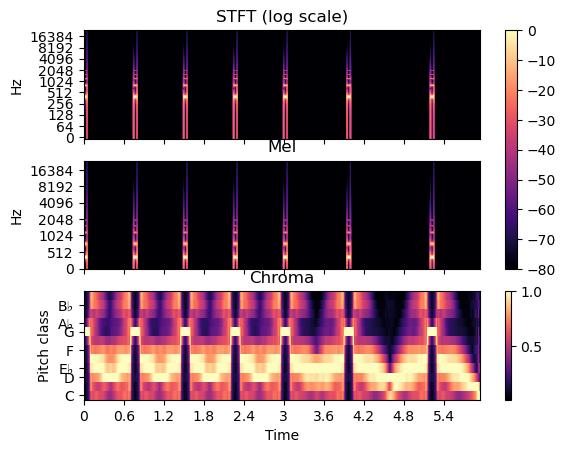

In [21]:
# Calculate features to plot
hop_length = 64
D = librosa.stft(sequence, hop_length = hop_length)
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)

M = librosa.feature.melspectrogram(y = sequence, sr = sample_rate,
                                   hop_length = hop_length)
M_db = librosa.power_to_db(M, ref = np.max)

chroma = librosa.feature.chroma_cqt(y = sequence, sr = sample_rate,
                                   hop_length = hop_length)

# ---- Plot the Sequence ----
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

# Original spectrogram
img1 = librosa.display.specshow(S_db, sr = sample_rate, hop_length = hop_length,
                                x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='STFT (log scale)')

# Mel spectrogram
img2 = librosa.display.specshow(M_db, sr = sample_rate, hop_length = hop_length,
                                x_axis='time', y_axis='mel', ax=ax[1])
ax[1].set(title='Mel')

# Chroma features
img3 = librosa.display.specshow(chroma, sr = sample_rate, hop_length = hop_length,
                                x_axis='time', y_axis='chroma',
                                key='Eb:maj', ax=ax[2])
ax[2].set(title='Chroma')

for ax_i in ax:
    ax_i.label_outer()
fig.colorbar(img1, ax=[ax[0], ax[1]])
fig.colorbar(img3, ax=[ax[2]])